In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers

import io

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
sims_2d_path = '../data/2d_data/plane_sims/plane_sim_1100_648_486_1.npy'
planes_path = '../data/2d_data/planes/planes_1100_648_486_1.npy'
model_weights_path = '../models/2d_models/temp/test1'

# Layers

#### Shifted + scaled tanh activation function

In [7]:
# Batchnorm epsilon
BN_EPS = 1e-4

class ConvBnRelu2d(layers.Layer):
    def __init__(self, out_channels, kernel_size=(3, 3), padding='same'):
        super(ConvBnRelu2d, self).__init__()
        self.conv = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding='same', use_bias=False)
        self.bn = layers.BatchNormalization(epsilon=BN_EPS)
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class TanhScale(layers.Layer):
    def __init__(self):
        super(TanhScale, self).__init__()
    
    def call(self, x):
        x = K.tanh(x)
        x = (x + 1) * 0.5
        return x * m

class StackEncoder(layers.Layer):
    def __init__(self, y_channels, kernel_size=3):
        super(StackEncoder, self).__init__()
        padding = (kernel_size - 1) // 2
        self.encode = keras.Sequential([
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same')
        ])
        self.max_pool = layers.MaxPool2D(pool_size=2, strides=2)
        
    def call(self, x):
        x = self.encode(x)
        x_small = self.max_pool(x)
        return x, x_small


class StackDecoder(layers.Layer):
    def __init__(self, y_channels, kernel_size=3):
        super(StackDecoder, self).__init__()
        padding = (kernel_size - 1) // 2
        
        self.decode = keras.Sequential([
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ]
        )
        
        
    def call(self, x, down_tensor):
        x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
        
        # Calculate cropping for down_tensor to concatenate with x
        _, h2, w2, _ = down_tensor.shape
        _, h1, w1, _ = x.shape
        h_diff, w_diff = h2 - h1, w2 - w1
        
        cropping = ((int(np.ceil(h_diff / 2)), int(np.floor(h_diff / 2))),
                    (int(np.ceil(w_diff / 2)), int(np.floor(w_diff / 2))))
        down_tensor = layers.Cropping2D(cropping=cropping)(down_tensor)        
        x = layers.concatenate([x, down_tensor], axis=3)
        x = self.decode(x)
        return x

# Model

In [8]:
class UNet_2d(keras.Model):
    def __init__(self):
        super(UNet_2d, self).__init__()

        self.down1 = StackEncoder(24, kernel_size=3) # 256
        self.down2 = StackEncoder(64, kernel_size=3)  # 128
        self.down3 = StackEncoder(128, kernel_size=3)  # 64
        self.down4 = StackEncoder(256, kernel_size=3)  # 32
        self.down5 = StackEncoder(512, kernel_size=3)  # 16
        

        self.up5 = StackDecoder(256, kernel_size=3)  # 32
        self.up4 = StackDecoder(128, kernel_size=3)  # 64
        self.up3 = StackDecoder(64, kernel_size=3)  # 128
        self.up2 = StackDecoder(24, kernel_size=3)  # 256
        self.up1 = StackDecoder(24, kernel_size=3)  # 512
        self.classify = layers.Conv2D(filters=1, kernel_size=1, use_bias=True)
        
        self.center = ConvBnRelu2d(512, kernel_size=3, padding='same')
        
        
    def call(self, x):
        out = x;
        down1_tensor, out = self.down1(out)
        down2_tensor, out = self.down2(out)
        down3_tensor, out = self.down3(out)
        down4_tensor, out = self.down4(out)
        down5_tensor, out = self.down5(out)

        out = self.center(out)
        
        out = self.up5(out, down5_tensor)
        out = self.up4(out, down4_tensor)
        out = self.up3(out, down3_tensor)
        out = self.up2(out, down2_tensor)
        out = self.up1(out, down1_tensor)

        out = self.classify(out)
        out = tf.squeeze(out, axis=3)
        
        return out

In [9]:
#         out = self.activation_fn(out)
#         self.activation_fn = TanhScale()
#       self.bn = layers.BatchNormalization(epsilon=BN_EPS)

# Data Loading, Preprocessing

In [11]:
def normalize(x, eps):
    return (x - np.mean(x, axis=0)) / (np.std(x, axis=0) + eps)

In [12]:
# Load in forward model simulations
sims_2d = np.load(sims_2d_path)
n, y, x = sims_2d.shape
sims_2d = sims_2d[..., np.newaxis] # Expand to channel dimension
sims_2d = sims_2d.astype(np.float32) # Cast to float32
input_shape = sims_2d.shape

# Load in ground truth
planes = np.load(planes_path)

# Crop to target image size
m = 1
planes = planes[:, 4:644, 3:483]

# Standard normalize input/ground truth
eps = 1e-4

planes = normalize(planes, eps)
sims_2d = normalize(sims_2d, eps)

In [13]:
# assert planes.min() == 0.0 and planes.max() == m, "planes min/max scaling issue"
# assert sims_2d.min() == 0.0 and sims_2d.max() == m, "sims_2d min/max scaling issue"

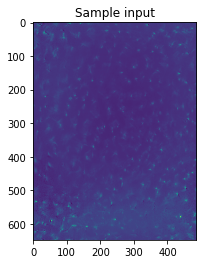

In [14]:
plt.title("Sample input")
plt.imshow(sims_2d[0,:,:,0])
plt.show()

# Logging

In [ ]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def scaled_mse_loss(y_actual,y_pred):
    loss = K.square((y_actual-y_pred))
#     loss = K.sqrt(loss)
    loss = K.sum(loss)
    return loss

def plot_image_tensorboard(epoch, logs):
    # Create a plot to visualize image reconstruction progress
    i = 2
    # Call the model to get prediction
    pred = model.predict(sims_2d[i][np.newaxis])

    # Create a mpl figure
    figure = plt.figure(figsize=(10,10))

    # Plot the prediction
    plt.subplot(1, 2, 1)
    plt.title("prediction")
    plt.imshow(pred[0])
    # Plot groundtruth
    plt.subplot(1, 2, 2)
    plt.title("ground truth")
    plt.imshow(planes[i])
    plot_image = plot_to_image(figure)
    with file_writer.as_default():
        tf.summary.image("Prediction vs Ground Truth", plot_image, step=epoch)

import datetime
log_dir=os.path.join('logs_2d', 'fit') + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=1000000)
file_writer = tf.summary.create_file_writer(log_dir)

plot_image_tensorboard_cb = keras.callbacks.LambdaCallback(on_epoch_end=plot_image_tensorboard)

# Training

In [ ]:
model = UNet_2d()
adam = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
# model.compile(optimizer=adam, loss=scaled_mse_loss, metrics=['mean_squared_error'])
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
model.build(input_shape)
model.summary()

In [ ]:
EPOCHS = 200
BATCH_SIZE = 8
TRAIN_LENGTH = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_x = sims_2d[:TRAIN_LENGTH]
train_y = planes[:TRAIN_LENGTH]

model.fit(x=train_x, y=train_y, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, callbacks=[plot_image_tensorboard_cb, 
                                                                                           tensorboard_callback])

In [ ]:
model.save_weights(model_weights_path, save_format='tf')

# Timing Tests 

In [16]:
model = UNet_2d()
model.load_weights('../models/2d_models/temp/test1')

In [17]:
import time

Prediction time per sample: 0.11254304309841245 s


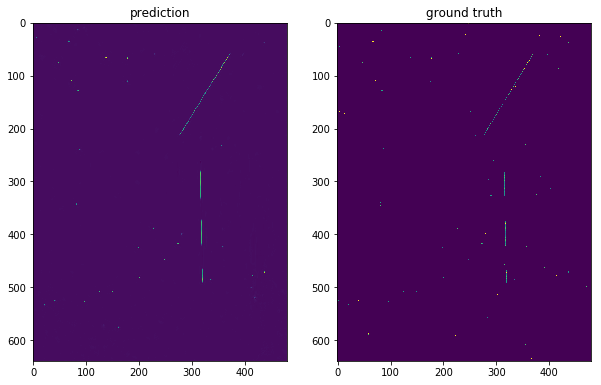

In [37]:
j = 1000
num_predict = 10

t0 = time.perf_counter()
pred = model.predict(sims_2d[j:j+num_predict])
t1 = time.perf_counter()

print('Prediction time per sample:', (t1 - t0) / num_predict, 's')

# Create a mpl figure
figure = plt.figure(figsize=(10,10))

# Plot the prediction
plt.subplot(1, 2, 1)
plt.title("prediction")
plt.imshow(pred[0])
# Plot groundtruth
plt.subplot(1, 2, 2)
plt.title("ground truth")
plt.imshow(planes[j])
plt.show()